# Introduction

CausalDataGenerator is a software that learns causal relationships based on a given data and causal relationships. This notebook discusses the case of working with data containing discrete variables.

## Import and settings

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.special import expit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import graphviz as gv
from IPython.display import Markdown
import lingam

print([np.__version__, pd.__version__, gv.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(100)

from lingam.experimental.cdg import CausalDataGenerator
    
np.random.seed(0)

['1.23.4', '1.5.0', '0.19.1', '1.7.1']


# Creating test data

## Causal graph

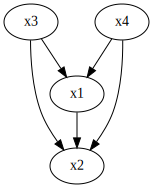

## Scatter matrix

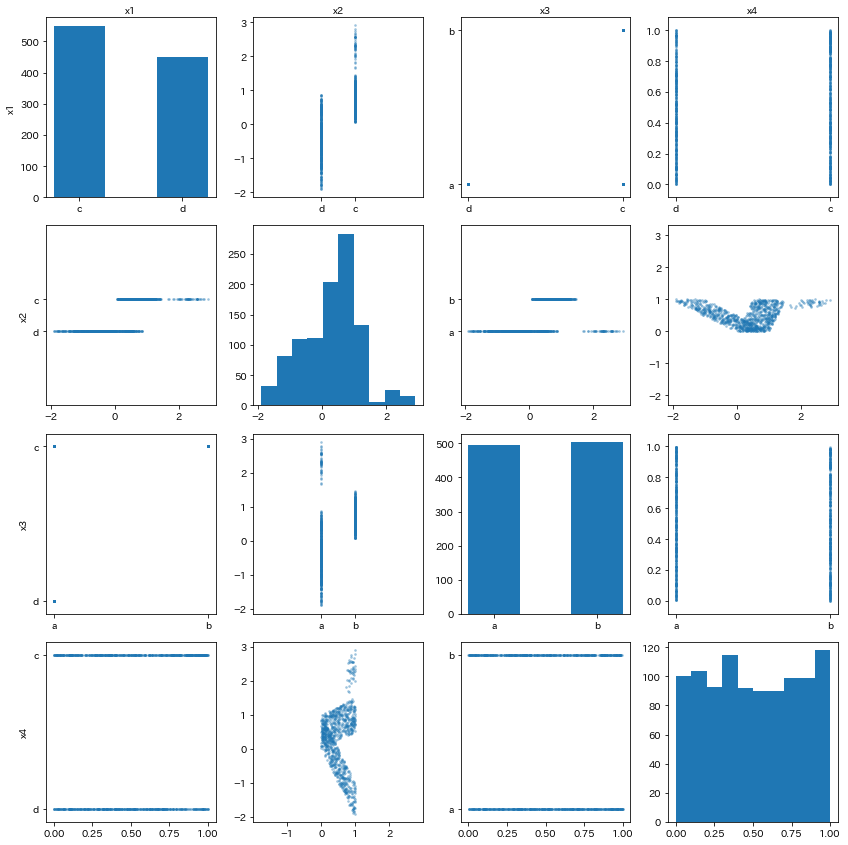

In [2]:
N = 1000

x3 = np.random.choice(["a", "b"], size=N)
x4 = np.random.uniform(size=N)
x1 = np.empty(N, dtype=str)
for i, (x3_, x4_) in enumerate(zip(x3, x4)):
    p = 1.5 * x4_
    p += -2 if x3_ == "a" else 0.5
    p += np.random.uniform()
    x1[i] = "c" if expit(p) > 0.5 else "d"
x2 = np.random.uniform(size=N)
for i, (x1_, x3_, x4_) in enumerate(zip(x1, x3, x4)):
    if x3_ == "a" and x1_ == "c":
        x2[i] += 2 * x4_
    elif x3_ == "a" and x1_ == "d":
        x2[i] += -2 * x4_
    elif x3_ == "b" and x1_ == "c":
        x2[i] += 0.5 * x4_
    elif x3_ == "b" and x1_ == "d":
        x2[i] += -0.5 * x4_
X = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4})
X["x1"] = pd.Categorical(X["x1"])
X["x3"] = pd.Categorical(X["x3"])

display(Markdown("## Causal graph"))
graph = gv.Digraph()
graph.edges([("x3", "x1"), ("x4", "x1"), ("x3", "x2"), ("x4", "x2"), ("x1", "x2")])
display(graph)

def draw_histogram(df, s=3, suptitle=None):
    fig, axes = plt.subplots(1, df.shape[1], figsize=(df.shape[1] * s, s))
    
    for i in range(df.shape[1]):
        if df.iloc[:, i].dtype == "category":
            axes[i].bar(*np.unique(df.iloc[:, i], return_counts=True), width=0.5)
        else:
            axes[i].hist(df.iloc[:, i])
        axes[i].set_xlabel(df.columns[i])
        
    if suptitle is not None:
        plt.suptitle(suptitle)
        
    plt.tight_layout()
    plt.show()

def draw_scatter_matrix(true, pred, s=3, supxlabel="", supylabel="", diagonal_hist=True):
    n_cols = true.shape[1]
    
    fig, axes = plt.subplots(n_cols, n_cols, figsize=(n_cols * s, n_cols * s))
    
    for i, c in enumerate(true.columns):
        for j, c2 in enumerate(true.columns):
            if i == j and diagonal_hist is True:
                if true[c].dtype == "category":
                    axes[i, j].bar(*np.unique(true[c], return_counts=True), width=0.5)
                else:
                    axes[i, j].hist(true[c])
            else:
                axes[i, j].scatter(true[c], pred[c2], alpha=0.3, s=3)
                axes[i, j].axis("equal")
            
            if i == 0:
                axes[i, j].set_xlabel(c2)    
                axes[i, j].xaxis.set_label_position("top") 
            if j == 0:
                axes[i, j].set_ylabel(c)

    fig.supxlabel(supxlabel, va="top")
    fig.supylabel(supylabel)
    plt.tight_layout()
    plt.show()

display(Markdown("## Scatter matrix"))
draw_scatter_matrix(X, X)

# Fitting models to the data based on the given causal roles

For the data created, x1 has the causal role of "cause", x2 has the role of "effect", and x3 and x4 have the role of "adjustment". Run fit() with data and causal roles to estimate the "cause" and "effect" models.

In [3]:
gen = CausalDataGenerator()
gen.fit(X, "x1", "x2", adjustments=["x3", "x4"])

By default, the "cause" and "effect" models use linear regression when the objective variable is a continuous variable and logistic regression when it is a discrete variable.

If the explanatory variable contains discrete variables, CausalDataGenerator uses OneHotEncoding and ColumnTransformer by default.　If you want to use a particular column as a categorical variable, you must use pd.Categorical for that column.

In [4]:
gen.model_cause_

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['x3'], dtype='object')),
                                                 ('numeric', 'passthrough',
                                                  Index(['x4'], dtype='object'))])),
                ('estimator', LogisticRegression())])

In [5]:
gen.model_effect_

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['x1', 'x3'], dtype='object')),
                                                 ('numeric', 'passthrough',
                                                  Index(['x4'], dtype='object'))])),
                ('estimator', LinearRegression())])

Because "cause" is a categorical variable, it has no error.

In [6]:
gen.error_cause_

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
995   NaN
996   NaN
997   NaN
998   NaN
999   NaN
Name: x1, Length: 1000, dtype: float64

In [7]:
gen.error_effect_

0      0.591402
1     -0.424107
2      0.273843
3     -0.218439
4      0.249809
         ...   
995    0.697283
996    0.359850
997    0.206405
998   -0.673234
999    0.392625
Name: x2, Length: 1000, dtype: float64

## Change the model for fit()

You can change the model used by fit() from the default machine learning model by specifying a scikit-learn machine learning model in the `model_effect_` or `model_cause_` arguments.

In [8]:
transformers = [
    ("categorical", OneHotEncoder(sparse_output=False), ["x1", "x3"]),
    ("numeric", StandardScaler(), ["x4"]),
]
transformer = ColumnTransformer(transformers=transformers)

model = Pipeline([
    ("transformer", transformer),
    ("estimator", MLPRegressor(max_iter=500))
])

param_grid = {
    "estimator__hidden_layer_sizes": [(10, 10), (10, 10, 10)],
}
model_effect = GridSearchCV(model, param_grid)

gen2 = CausalDataGenerator()
gen2.fit(X, "x1", "x2", adjustments=["x3", "x4"], model_effect=model_effect)

gen2.model_effect_

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['x1',
                                                                          'x3']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['x4'])])),
                                       ('estimator',
                                        MLPRegressor(max_iter=500))]),
             param_grid={'estimator__hidden_layer_sizes': [(10, 10),
                                                           (10, 10, 10)]})

# Data Generation
CausalDataGenerator can generate data using the result of fit().

In [9]:
data = gen.generate()
data

,x1,x2,x3,x4
0,d,0.230562,a,0.310381
1,c,0.422085,b,0.373035
2,c,1.020669,b,0.524970
3,d,-0.867365,a,0.750595
4,c,1.121880,b,0.333507
...,...,...,...,...
995,d,0.519548,a,0.030427
996,d,0.075427,a,0.193623
997,d,-0.024796,a,0.112250
998,c,0.389266,b,0.042364


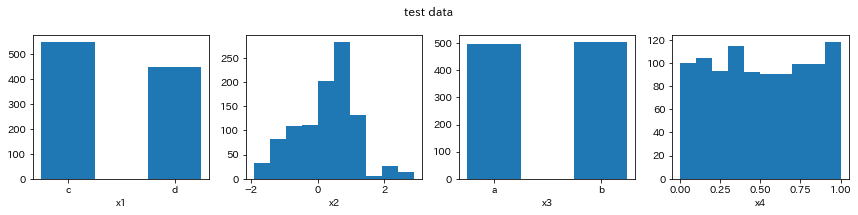

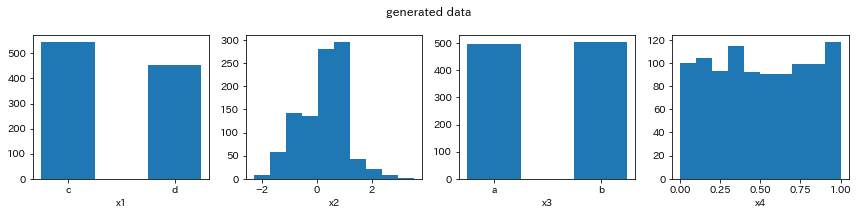

In [10]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

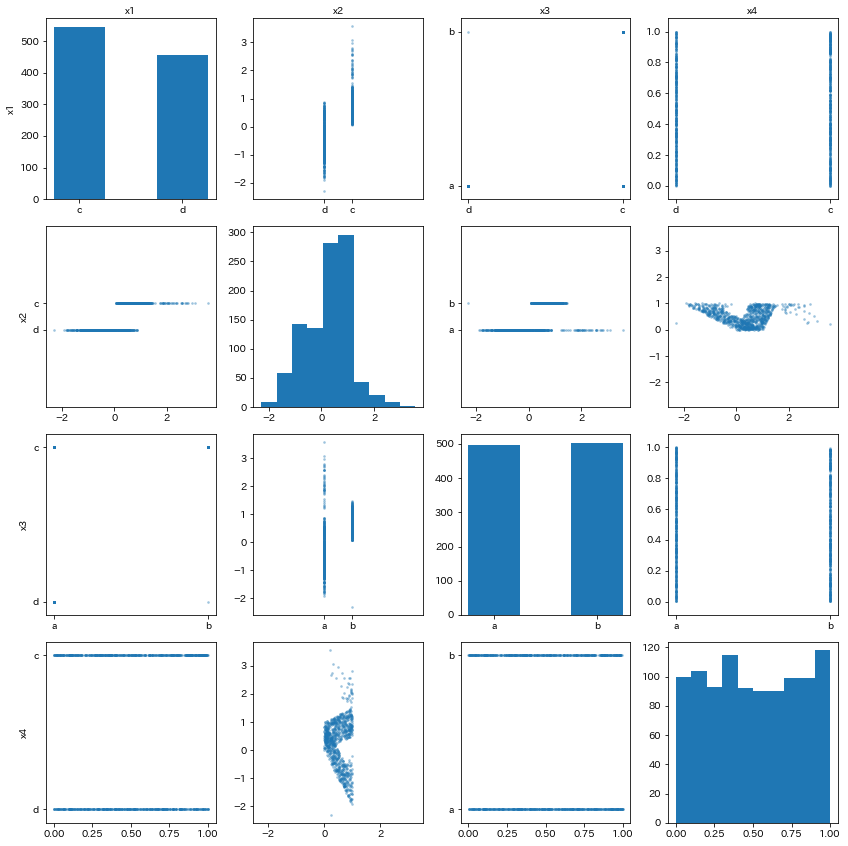

In [11]:
draw_scatter_matrix(data, data)

# Data generation with changing endogenous variables

In [12]:
data = gen.generate(interv_endog={"x1": np.full(N, "c")})

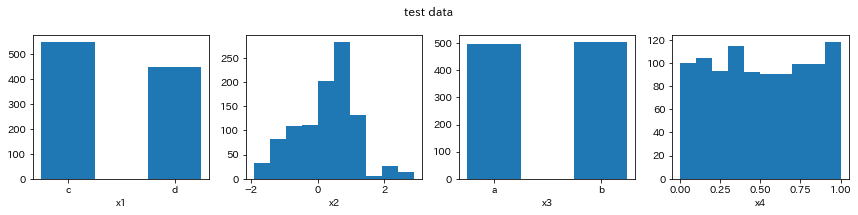

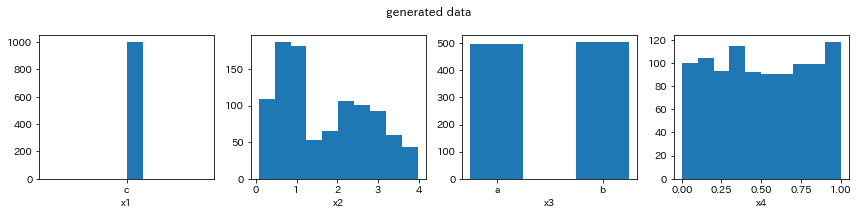

In [13]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

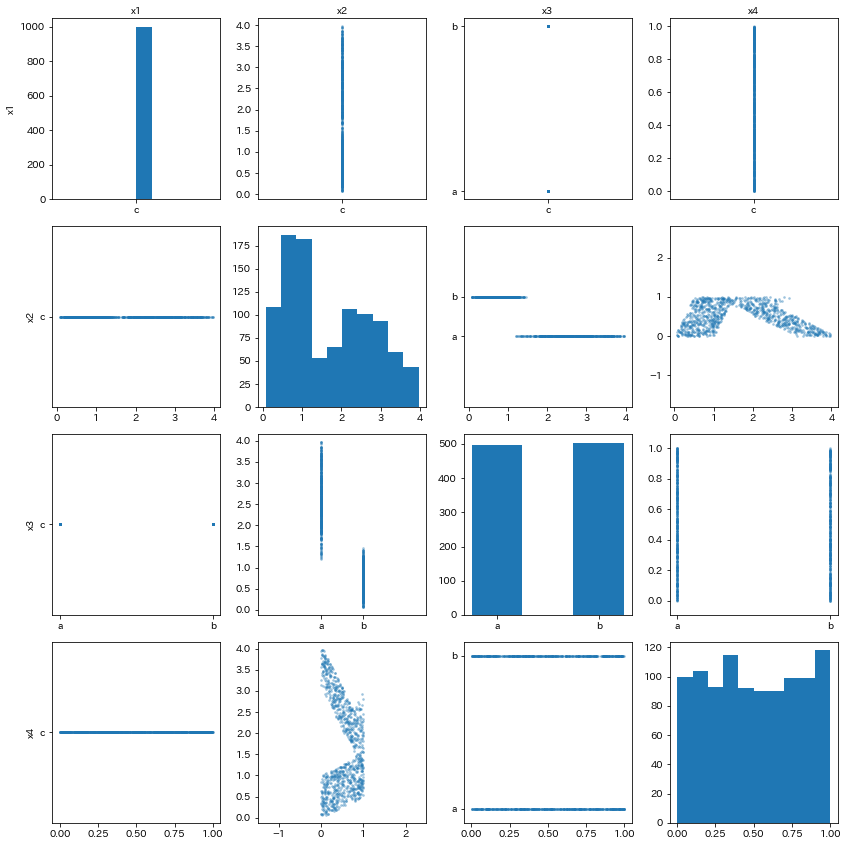

In [14]:
draw_scatter_matrix(data, data)

# Data generation with changing exogenous variables
Here, the noise is prepared using the estimated probability density function.

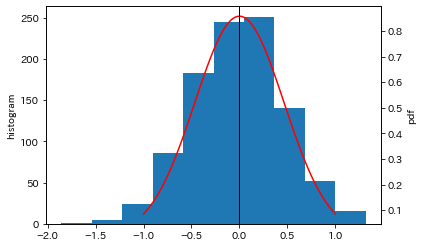

In [15]:
# Assume normal distribution for residuals of x2
params = st.norm.fit(gen.error_effect_, floc=0)
samples = st.norm(*params).rvs(X.shape[0])

plt.hist(samples)
plt.ylabel("histogram")
x = np.linspace(-1, 1, 100)
ax = plt.twinx()
ax.plot(x, st.norm(*params).pdf(x), color="red")
ax.set_ylabel("pdf")
plt.axvline(0, color="black", lw=1)
plt.show()

In [16]:
data = gen.generate(interv_exog={"x2": samples})

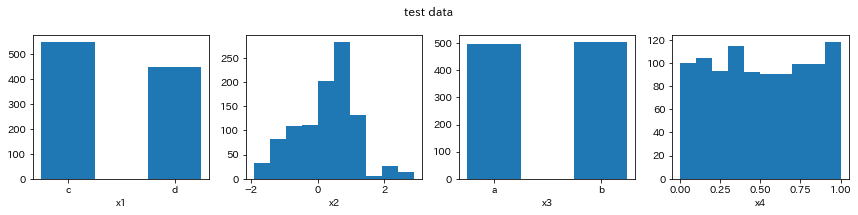

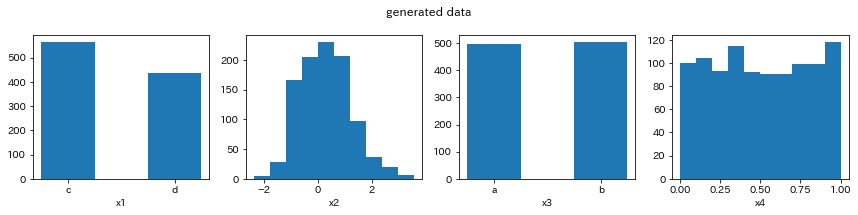

In [17]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

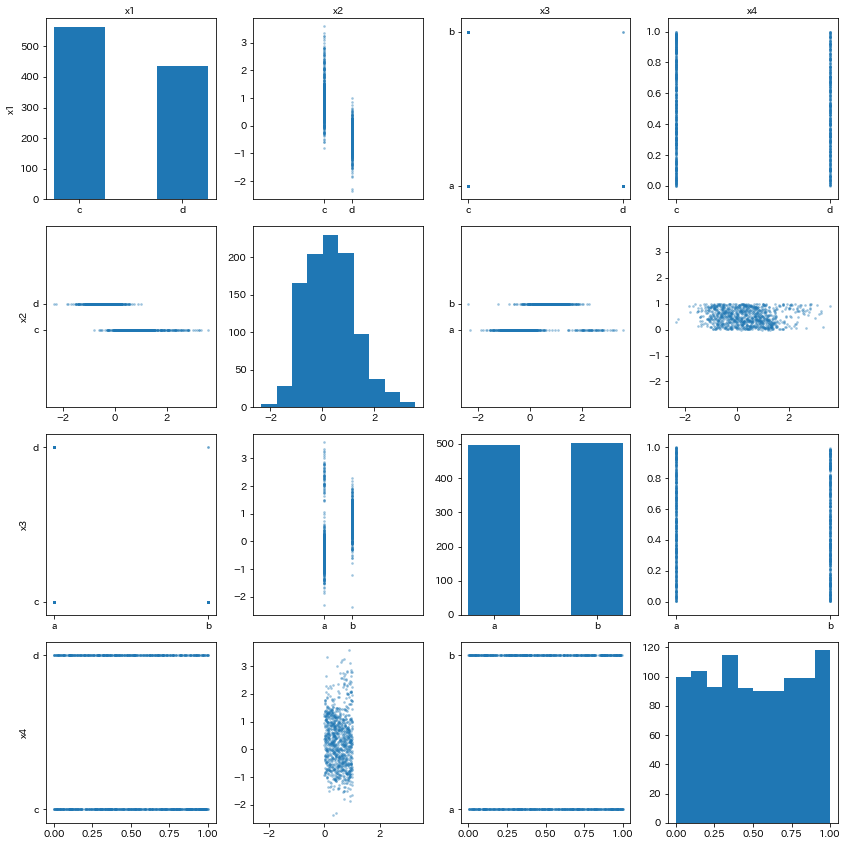

In [18]:
draw_scatter_matrix(data, data)

# Data generation with changing the effect model

In [19]:
# make multi layer perceptron model
transformers = [
    ("categorical", OneHotEncoder(sparse_output=False), ["x1", "x3"]),
    ("numeric", StandardScaler(), ["x4"]),
]
transformer = ColumnTransformer(transformers=transformers)

model = Pipeline([
    ("transformer", transformer),
    ("estimator", MLPRegressor(max_iter=500))
])

param_grid = {
    "estimator__hidden_layer_sizes": [(10, 10), (10, 10, 10)],
}
cv = GridSearchCV(model, param_grid)
cv.fit(X[["x1", "x3", "x4"]], X["x2"])

# The arguments are explanatory variables, residuals and user-defined args.
# The output is the value of the generated "effect" variable.
def effect_model(X, error, args):
    generated = args.predict(X) + error
    return generated

# The user must provide "effect_model" as an argument. If necessary, "effect_model_args" can also be given.
data = gen.generate(effect_model=effect_model, effect_model_args=cv)

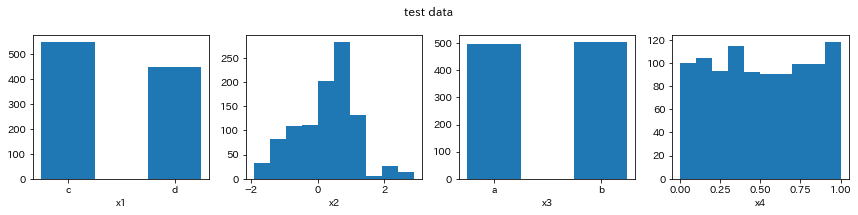

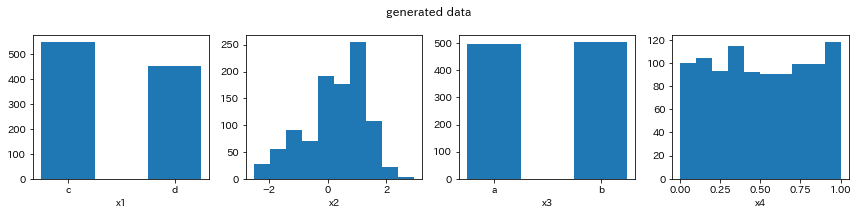

In [20]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

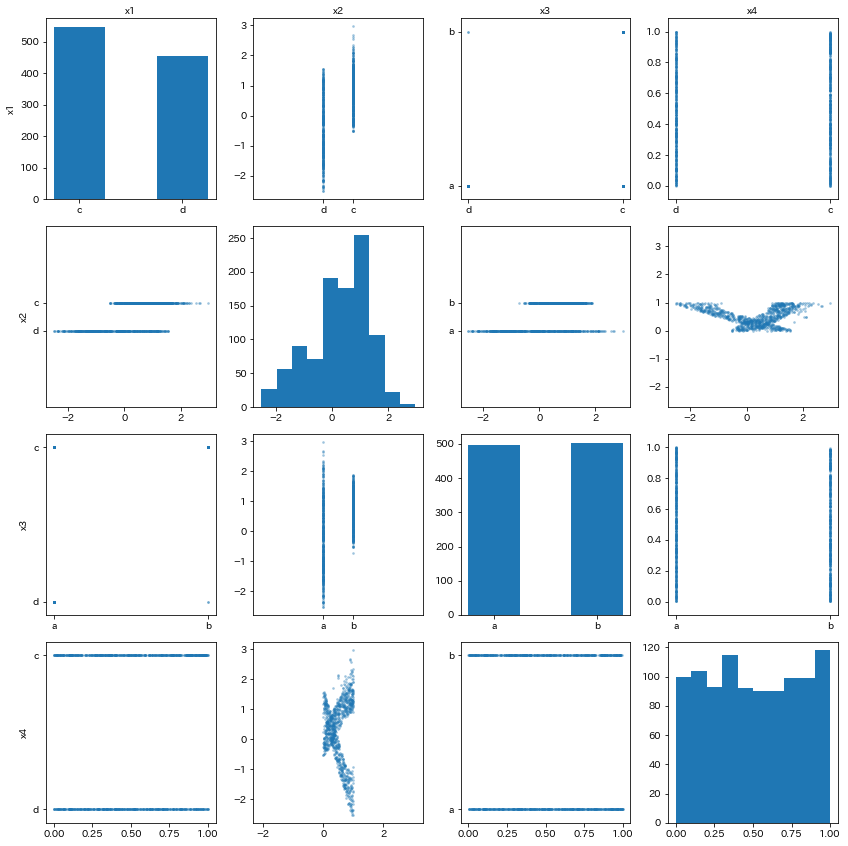

In [21]:
draw_scatter_matrix(data, data)

# Data generation with changing the cause model

In [22]:
def cause_model(X, error, args):
    # The explanatory variables for x1 are x3 and x4.
    # The contents of X.columns are [*adjustments]
    print(X.columns)

    p = args.predict_proba(X)
    
    generated = []
    for p_ in p:
        generated.append(np.random.choice(args.classes_, p=p_))
    return generated

data = gen.generate(cause_model=cause_model, cause_model_args=gen.model_cause_)

Index(['x3', 'x4'], dtype='object')


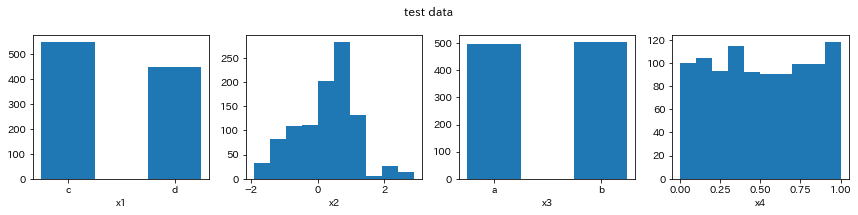

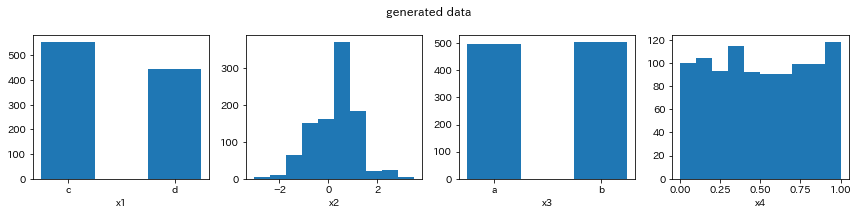

In [23]:
draw_histogram(X, suptitle="test data")
draw_histogram(data, suptitle="generated data")

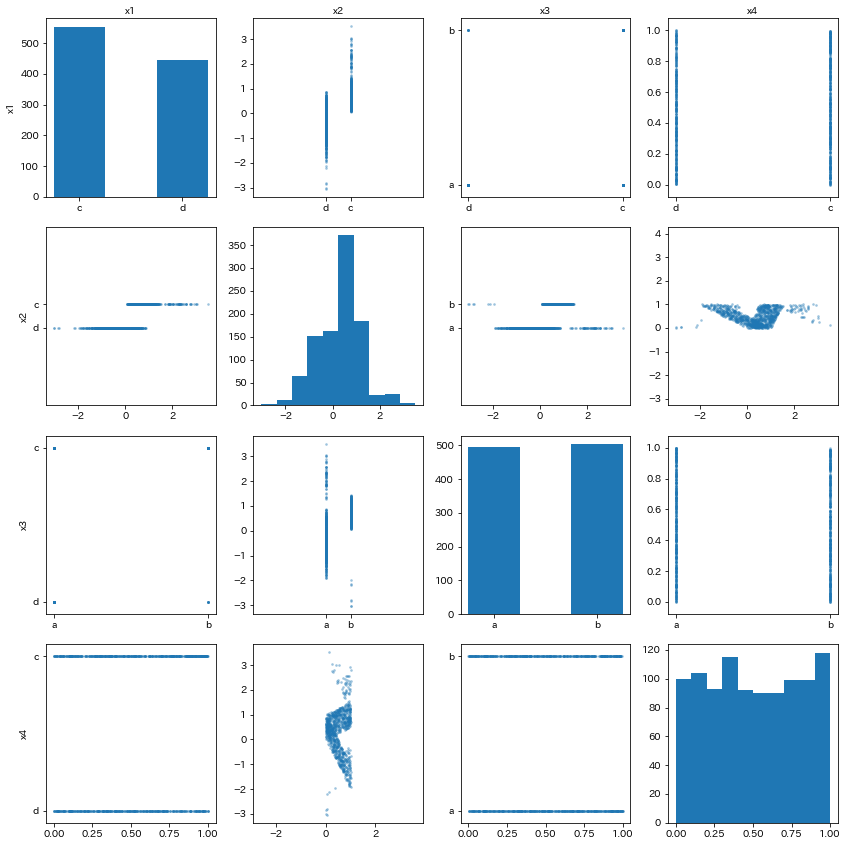

In [24]:
draw_scatter_matrix(data, data)